In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
style_path = tf.keras.utils.get_file("style.jpg", "http://bit.ly/2mGfZIq")

337723/337723 [==============================] - 0s 0us/step


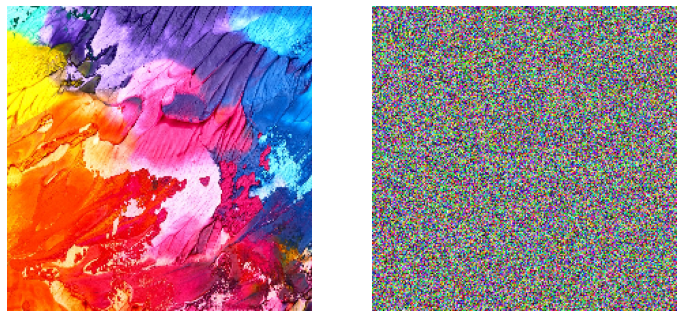

In [21]:
# 원본 이미지
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image/255.0

# 생성 이미지 (후에 학습을 통해 원본 이미지에 가까워지게)
target_image = tf.random.uniform(style_image.shape)

# 시각화
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(style_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(target_image)
plt.axis('off')
plt.show()

In [22]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers :
    print(layer.name)

80134624/80134624 [==============================] - 8s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [23]:
style_layers = ['block1_conv1', "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

In [24]:
def gram_matrix(input_tensor) :
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a=True)
    return gram/tf.cast(n, tf.float32)

In [25]:
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image/255.0

style_batch = style_image.astype("float32")
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(preprocess_input(style_batch*255.0))

(1, 224, 224, 64)


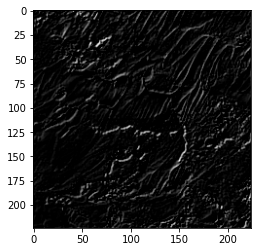

In [47]:
print(style_output[0].shape)
plt.imshow(tf.squeeze(style_output[0][:,:,:,0],0), cmap="gray")

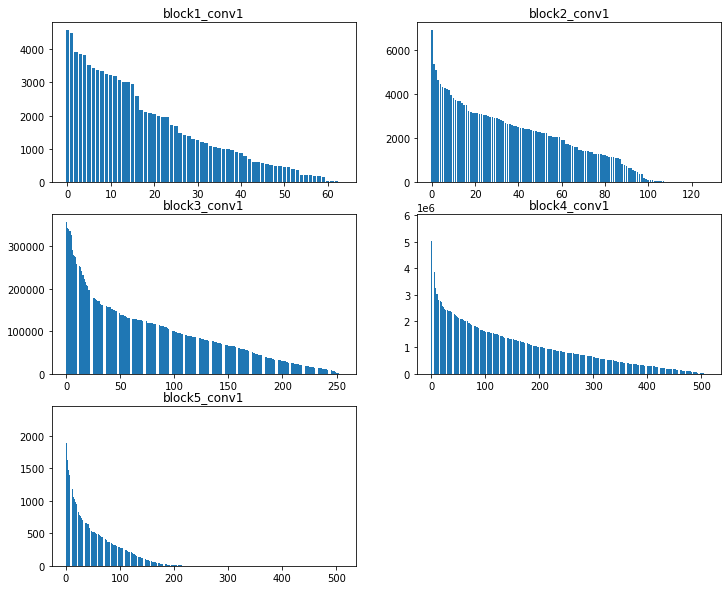

In [48]:
style_outputs = [gram_matrix(out) for out in style_output]

plt.figure(figsize=(12,10))
for c in range(5) :
    plt.subplot(3,2,c+1)
    array = sorted(style_outputs[c].numpy()[0].tolist())
    array = array[::-1]
    plt.bar(range(style_outputs[c].shape[0]), array)
    plt.title(style_layers[c])
plt.show()

In [51]:
def get_outputs(image) :
    image_batch = tf.expand_dims(image, axis=0)
    output = model(preprocess_input(image_batch*255.0))
    outputs = [gram_matrix(out) for out in output]
    return outputs

def get_loss(outputs, style_outputs) :
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])

def clip01(image) :
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [53]:
opt = tf.optimizers.Adam(learning_rate=0.2, beta_1 = 0.99, epsilon=1e-1)

In [54]:
@tf.function()
def train_step(image) :
    with tf.GradientTape() as tape :
        outputs = get_outputs(image)
        loss = get_loss(outputs, style_outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip01(image))

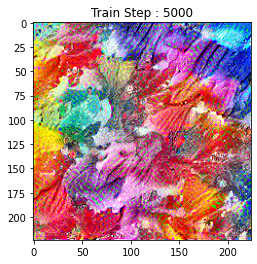

Total time : 155.5


In [58]:
import IPython.display as display
import time
import imageio

start = time.time()
image = tf.Variable(target_image)

epochs = 50
steps_per_epochs = 100
step = 0

for n in range(epochs) :
    for m in range(steps_per_epochs) :
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs -1 :
        imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train Step : {}".format(step))
    plt.show()
    
end = time.time()
print("Total time : {:.1f}".format(end-start))

In [70]:
def high_pass_xy(image) :
    x_var = image[:,1:,:] - image[:,:-1,:]
    y_var = image[1:,:,:] - image[:-1,:,:]
    return x_var, y_var

def total_variation_loss(image) :
    x_deltas, y_deltas = high_pass_xy(image)
    return(tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2))

In [71]:
print("target   :", total_variation_loss(image.read_value()))
print("noise    :", total_variation_loss(tf.random.uniform(style_image.shape)))
print("original :", total_variation_loss(style_image))

target   : tf.Tensor(0.10164342, shape=(), dtype=float32)
noise    : tf.Tensor(0.33280173, shape=(), dtype=float32)
original : tf.Tensor(0.03423192978061708, shape=(), dtype=float64)


In [72]:
total_variation_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image) :
    with tf.GradientTape() as tape :
        outputs = get_outputs(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss = loss + total_variation_weight * total_variation_loss(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip01(image))

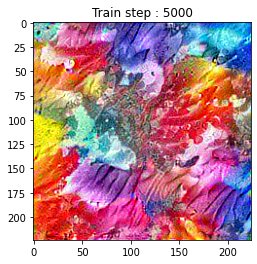

Total Time : 159.0


In [75]:
start = time.time()
target_image = tf.random.uniform(style_image.shape)
image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs) :
    for m in range(steps_per_epoch) :
        step += 1
        train_step(image)
    if n % 5 ==0 or n == epochs -1 :
        imageio.imwrite("style_variation_epoch_{0}.png".format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step : {}".format(step))
    plt.show()

end = time.time()
print("Total Time : {0:.1f}".format(end-start))

In [77]:
import matplotlib.pyplot as plt
import cv2

content_path = tf.keras.utils.get_file('content.jpg', "http://bit.ly/2mAfUX1")

754420/754420 [==============================] - 0s 0us/step


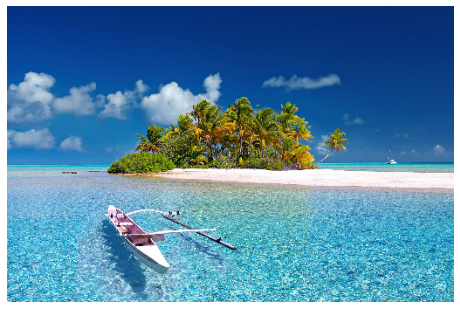

In [81]:
content_image = plt.imread(content_path)
max_dim = 512
long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim

new_height = int(content_image.shape[0] * scale)
new_weight = int(content_image.shape[1] * scale)
content_image = cv2.resize(content_image, dsize=(new_weight, new_height))
content_image = content_image / 255.0

plt.figure(figsize=(8,8))
plt.imshow(content_image)
plt.axis('off')
plt.show()

In [82]:
content_batch = content_image.astype("float32")
content_batch = tf.expand_dims(content_batch, axis=0)
content_layers = ["block5_conv2"]

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

In [83]:
def get_content_output(image) :
    image_batch = tf.expand_dims(image, axis=0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

def get_content_loss(image, content_output) :
    return tf.reduce_sum(tf.reduce_mean((image-content_output)**2))

In [90]:
# 8.61 content loss를 loss 계산식에 추가
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip01(image))

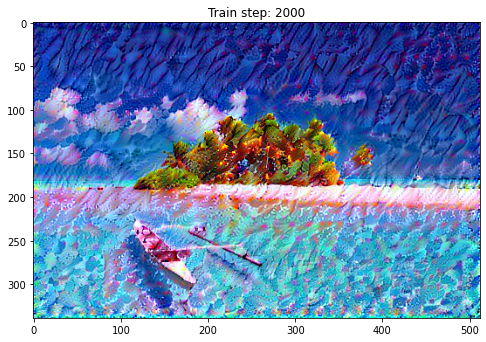

Total time: 375.9


In [91]:
# 8.62 Neural Style Transfer 실행
start = time.time()

# target_image = tf.random.uniform(content_image.shape)
image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))